In [1]:
skip_training = False  # Set this flag to True before validation and submission

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [3]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## FashionMNIST dataset

Let us use the FashionMNIST dataset. It consists of 60,000 training images of 10 classes: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'.

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.5,), (0.5,))  # Scale images to [-1, 1]
])

trainset = torchvision.datasets.FashionMNIST(root='clothes_dataset', train=True, download=False, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='clothes_dataset', train=False, download=False, transform=transform)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False)

# VGG-style network

Let us now define a convolution neural network with an architecture inspired by the [VGG-net](https://arxiv.org/abs/1409.1556).

The architecture:
- A block of three convolutional layers with:
    - 3x3 kernel
    - 20 output channels
    - one pixel zero-pading on both sides
    - 2d batch normalization after each convolutional layer
    - ReLU nonlinearity after each 2d batch normalization layer
- Max pooling layer with 2x2 kernel and stride 2.
- A block of three convolutional layers with:
    - 3x3 kernel
    - 40 output channels
    - one pixel zero-pading on both sides
    - 2d batch normalization after each convolutional layer
    - ReLU nonlinearity after each 2d batch normalization layer
- Max pooling layer with 2x2 kernel and stride 2.
- One convolutional layer with:
    - 3x3 kernel
    - 60 output channels
    - *no padding*
    - 2d batch normalization after the convolutional layer
    - ReLU nonlinearity after the 2d batch normalization layer
- One convolutional layer with:
    - 1x1 kernel
    - 40 output channels
    - *no padding*
    - 2d batch normalization after the convolutional layer
    - ReLU nonlinearity after the 2d batch normalization layer
- One convolutional layer with:
    - 1x1 kernel
    - 20 output channels
    - *no padding*
    - 2d batch normalization after the convolutional layer
    - ReLU nonlinearity after the 2d batch normalization layer
- Global average pooling (compute the average value of each channel across all the input locations):
    - 5x5 kernel (the input of the layer should be 5x5)
- A fully-connected layer with 10 outputs (no nonlinearity)

Notes:
* Batch normalization is expected to be right after a convolutional layer, before nonlinearity.
* We recommend that you check the number of modules with trainable parameters in your network.

In [5]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        #first block of 3 convolutional layer
        self.conv11=nn.Conv2d(1,20,3,padding=1)
        self.bn11 = nn.BatchNorm2d(20) 
        self.conv12=nn.Conv2d(20,20,3,padding=1)
        self.bn12 = nn.BatchNorm2d(20) 
        self.conv13=nn.Conv2d(20,20,3,padding=1)
        self.bn13 = nn.BatchNorm2d(20) 
        
        #second block of 3 conv. layer
        self.conv21=nn.Conv2d(20,40,3,padding=1)
        self.bn21 = nn.BatchNorm2d(40) 
        self.conv22=nn.Conv2d(40,40,3,padding=1)
        self.bn22 = nn.BatchNorm2d(40) 
        self.conv23=nn.Conv2d(40,40,3,padding=1)
        self.bn23=nn.BatchNorm2d(40)
        
        # 1 conv layer
        self.conv3=nn.Conv2d(40,60,3)
        self.bn3 = nn.BatchNorm2d(60) 
        
        #1 conv layer
        self.conv4=nn.Conv2d(60,40,1)
        self.bn4 = nn.BatchNorm2d(40) 
        
        #1 conv layer
        self.conv5=nn.Conv2d(40,20,1)
        self.bn5 = nn.BatchNorm2d(20) 
        
        
        self.fc=nn.Linear(20,10)

    def forward(self, x, verbose=False):
        """
        Args:
          x of shape (batch_size, 1, 28, 28): Input images.
          verbose: True if you want to print the shapes of the intermediate variables.

        Returns:
          y of shape (batch_size, 10): Outputs of the network.
        """
        # First Block
        x = F.relu(self.bn11(self.conv11(x)))
        x = F.relu(self.bn12(self.conv12(x)))
        x = F.relu(self.bn13(self.conv13(x)))
        x = F.max_pool2d(x, (2, 2),stride=2)
        if verbose: print(f"After Block 1: {x.shape}")

        # --- Second Block ---
        x = F.relu(self.bn21(self.conv21(x)))
        x = F.relu(self.bn22(self.conv22(x)))
        x = F.relu(self.bn23(self.conv23(x)))
        x = F.max_pool2d(x, (2, 2),stride=2)
        if verbose: print(f"After Block 2: {x.shape}")

        # --- Remaining Convolutions ---
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        if verbose: print(f"After Block 3 & 4 & 5: {x.shape}")

        # --- Output Layer ---
        x = F.avg_pool2d(x, (5, 5))
        x = torch.flatten(x, 1) 
        if verbose: print(f"Before Linear: {x.shape}")
        
        output = self.fc(x)
        return output

In [6]:
def test_VGGNet_shapes():
    net = VGGNet()
    net.to(device)

    # Feed a batch of images from the training data to test the network
    with torch.no_grad():
        images, labels = next(iter(trainloader))
        images = images.to(device)
        print('Shape of the input tensor:', images.shape)

        y = net(images, verbose=True)
        assert y.shape == torch.Size([trainloader.batch_size, 10]), f"Bad y.shape: {y.shape}"

    print('Success')

test_VGGNet_shapes()

Shape of the input tensor: torch.Size([32, 1, 28, 28])
After Block 1: torch.Size([32, 20, 14, 14])
After Block 2: torch.Size([32, 40, 7, 7])
After Block 3 & 4 & 5: torch.Size([32, 20, 5, 5])
Before Linear: torch.Size([32, 20])
Success


In [7]:
# Check the number of layers
def test_vgg_layers():
    net = VGGNet()

    # get gradients for parameters in forward path
    net.zero_grad()
    x = torch.randn(1, 1, 28, 28)
    outputs = net(x)
    outputs[0,0].backward()

    n_conv_layers = sum(1 for module in net.modules()
                        if isinstance(module, nn.Conv2d) and next(module.parameters()).grad is not None)
    assert n_conv_layers == 9, f"Wrong number of convolutional layers ({n_conv_layers})"

    n_bn_layers = sum(1 for module in net.modules()
                      if isinstance(module, nn.BatchNorm2d) and next(module.parameters()).grad is not None)
    assert n_bn_layers == 9, f"Wrong number of batch norm layers ({n_bn_layers})"

    n_linear_layers = sum(1 for module in net.modules()
                          if isinstance(module, nn.Linear) and next(module.parameters()).grad is not None)
    assert n_linear_layers == 1, f"Wrong number of linear layers ({n_linear_layers})"

    print('Success')

def test_vgg_net():
    net = VGGNet()

    # get gradients for parameters in forward path
    net.zero_grad()
    x = torch.randn(1, 1, 28, 28)
    outputs = net(x)
    outputs[0,0].backward()

    parameter_shapes = sorted(tuple(p.shape) for p in net.parameters() if p.grad is not None)
    print(parameter_shapes)
    expected = [
        (10,), (10, 20), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,),
        (20,), (20,), (20,), (20, 1, 3, 3), (20, 20, 3, 3), (20, 20, 3, 3), (20, 40, 1, 1),
        (40,), (40,), (40,), (40,), (40,), (40,), (40,), (40,), (40,), (40,), (40,), (40,),
        (40, 20, 3, 3), (40, 40, 3, 3), (40, 40, 3, 3), (40, 60, 1, 1), (60,), (60,), (60,),
        (60, 40, 3, 3)]
    assert parameter_shapes == expected, "Wrong number of training parameters."

    print('Success')

test_vgg_layers()
test_vgg_net()

Success
[(10,), (10, 20), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20, 1, 3, 3), (20, 20, 3, 3), (20, 20, 3, 3), (20, 40, 1, 1), (40,), (40,), (40,), (40,), (40,), (40,), (40,), (40,), (40,), (40,), (40,), (40,), (40, 20, 3, 3), (40, 40, 3, 3), (40, 40, 3, 3), (40, 60, 1, 1), (60,), (60,), (60,), (60, 40, 3, 3)]
Success


# Train the network

In [8]:
# This function computes the accuracy on the test dataset
def compute_accuracy(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

### Training loop

Your task is to implement the training loop. The recommended hyperparameters:
* Adam optimizer with learning rate 0.01.
* Cross-entropy loss. Note that we did not use softmax nonlinearity in the final layer of our network. Therefore, we need to use a loss function with log_softmax implemented, such as [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss).
* Number of epochs: 10

We recommend you to use function `compute_accuracy()` defined above to track the accaracy during training. The test accuracy should be above 0.89.

**Note: function `compute_accuracy()` sets the network into the evaluation mode which changes the way the batch statistics are computed in batch normalization. You need to set the network into the training mode (by calling `net.train()`) when you want to perform training.**

In [9]:
net = VGGNet()

In [13]:
# Implement the training loop in this cell
if not skip_training:
    n_epochs=10
    criterion=nn.CrossEntropyLoss()
    optim=torch.optim.Adam(params=net.parameters(),lr=.01)
    print("start of the training loop")
    net.train()
    for n in range(n_epochs):
        # accuracy=compute_accuracy(net,testloader)
        # print(f'accuracy : {accuracy}, epoch : {n+1}')
        # net.train()
        print(f'epochs: {n}')
        for images,labels in trainloader:
            optim.zero_grad()
            images, labels = images.to(device), labels.to(device)
            outputs=net(images)
            
            loss=criterion(outputs,labels)
            loss.backward() #compute the gradients
            optim.step() #mets à jour les poids de l'optimiseur
            
    
    print("training_finished")
    accuracy=compute_accuracy(net,testloader)
    print(f'final accuracy : {accuracy}')
            

start of the training loop
epochs: 0
epochs: 1
epochs: 2
epochs: 3
epochs: 4
epochs: 5
epochs: 6
epochs: 7
epochs: 8
epochs: 9
training_finished
final accuracy : 0.9254


In [14]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
torch.save(net.state_dict(),f="model_VGG_conv")

In [15]:
# Compute the accuracy on the test set
accuracy = compute_accuracy(net, testloader)
print(f'Accuracy of the VGG net on the test images: {accuracy: .3f}')
assert accuracy > 0.89, 'Poor accuracy'
print('Success')

Accuracy of the VGG net on the test images:  0.925
Success


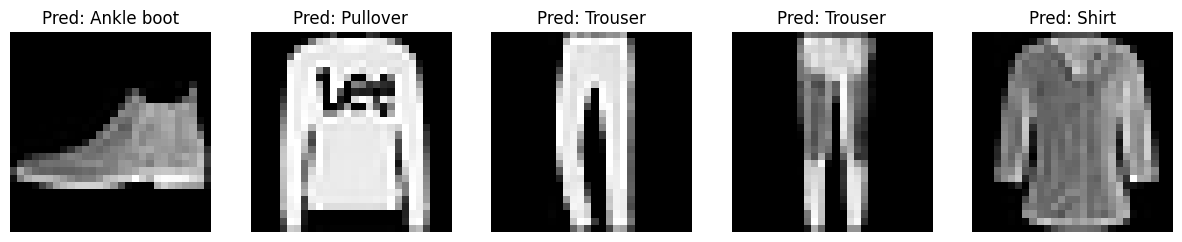

Ground truth:  Ankle boot   Pullover    Trouser    Trouser      Shirt
Predictions:   Ankle boot   Pullover    Trouser    Trouser      Shirt


In [16]:

# Set the network to evaluation mode
net.eval()

# 1. Grab a batch of data
with torch.no_grad():
    images, labels = next(iter(testloader))
    
    # 2. Compute predictions
    images_dev = images.to(device)
    outputs = net(images_dev)
    _, predicted = torch.max(outputs, 1)

# 3. Plot the first 5 images using Matplotlib
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    # PyTorch tensors are (C, H, W), Matplotlib needs (H, W, C)
    img = images[i].numpy().transpose((1, 2, 0))
    
    # If your images were normalized, you might need to un-normalize them here
    # img = img * std + mean 
    
    axes[i].imshow(img.squeeze(), cmap='gray' if img.shape[2] == 1 else None)
    axes[i].set_title(f"Pred: {classes[predicted[i]]}")
    axes[i].axis('off')

plt.show()

# 4. Print the text summary
print('Ground truth: ', ' '.join('%10s' % classes[labels[j]] for j in range(5)))
print('Predictions:  ', ' '.join('%10s' % classes[predicted[j]] for j in range(5)))